# Programmet har til formål at arbejde Populationsdata fra EUROSTAT, så det kan benyttes til estimationer


In [ ]:
import numpy             as np
import matplotlib.pyplot as plt           #We use it for construction of graphs, both 3D and 2D
import math

import pandas as pd

import json
import os
import requests

# spatial stuff
import geopandas as gpd
import fiona
import folium
import shapely
from descartes import PolygonPatch
from tqdm import tqdm



import Function


In [176]:
pip install opencage

Note: you may need to restart the kernel to use updated packages.


In [136]:
#DENNE CELLE IMPORTERER HOVEDAPOTEKSDATA. KUN BRUGBAR VED KOBLING AF DETTE MED POPULATION. ELLERS BENYTTES DETTE IKKE. 
df = pd.read_csv("https://raw.githubusercontent.com/Oliverkobaek/thesis_2020/master/Main_data_with_geodat.csv")
gdf = gpd.GeoDataFrame(gdf, geometry=gpd.points_from_xy(gdf.longitudes, gdf.latitudes))


# Vi importer data for henholdsvis population på grid niveau fra EUROSTAT (DK) og geografisk data for Kommune polygoner. 

In [120]:
import geopandas as gpd
url_map = "https://raw.githubusercontent.com/ok-dk/dagi/master/geojson/kommuner.geojson" # KOMMUNE DATA
kommuner = gpd.read_file(url_map)

# Convert to metres
kommuner.to_crs({'init':'epsg:25832'},inplace=True) #

bounds = kommuner.bounds

# get min or max of each column

min_max_bounds = []

for columns in bounds.columns[:2]:
    min_max_bounds.append(min(bounds[columns]))
    
for columns in bounds.columns[-2:]:
    min_max_bounds.append(max(bounds[columns]))
min_max_bounds

[441675.99999999994, 6049781.999990508, 892786.9996185575, 6402216.999996983]

VI IMPORTERER HER POPULATIONS DATA OPDELT PÅ GRID FRA EUROSTAT. 


<ipython-input-122-956906dac265>:3: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  GeoPopData.crs = {'init': 'epsg:25832', 'no_defs': True}


,TOT_P,GRD_ID,CNTR_CODE,METHD_CL,YEAR,DATA_SRC,TOT_P_CON_DT
0,2,1kmN3623E4468,DK,A,2011,DK,0
1,1,1kmN3623E4469,DK,A,2011,DK,0
2,3,1kmN3623E4470,DK,A,2011,DK,0
3,3,1kmN3624E4468,DK,A,2011,DK,0
4,7,1kmN3624E4469,DK,A,2011,DK,0
...,...,...,...,...,...,...,...
39002,2,1kmN3833E4337,DK,A,2011,DK,0
39003,8,1kmN3833E4338,DK,A,2011,DK,0
39004,3,1kmN3833E4339,DK,A,2011,DK,0
39005,3,1kmN3833E4340,DK,A,2011,DK,0


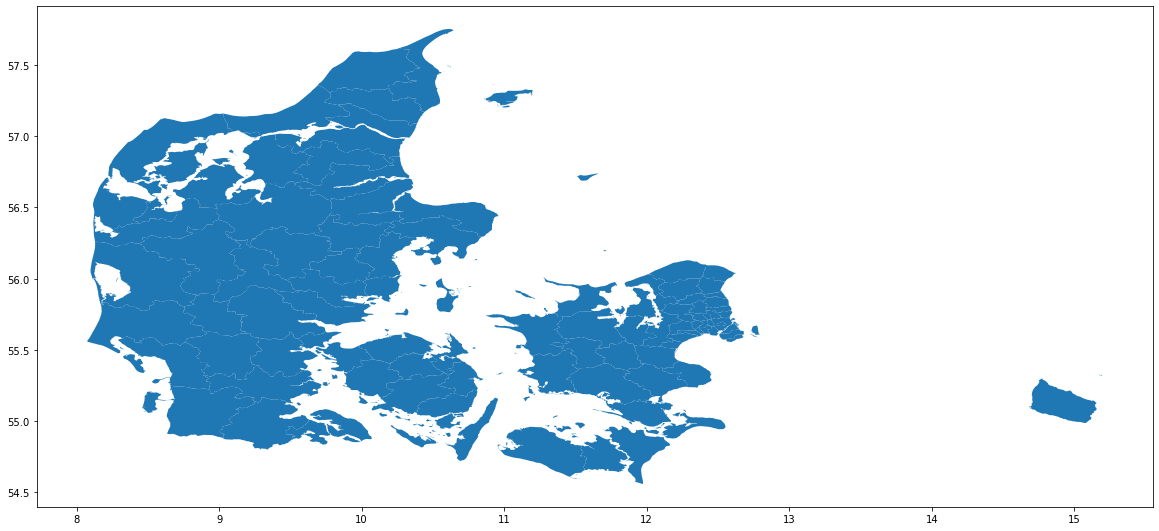

In [122]:
GeoPopData = pd.read_csv("https://raw.githubusercontent.com/Oliverkobaek/thesis_2020/master/GeoPopData_DK.csv") #POP DATA
#gdf.crs = {'init': 'epsg:4326', 'no_defs': True}
GeoPopData.crs = {'init': 'epsg:3035', 'no_defs': True}
url = "https://raw.githubusercontent.com/ok-dk/dagi/master/geojson/kommuner.geojson"
kommuner = gpd.read_file(url)
Kort = kommuner.plot(figsize=(20,20))
kommuner = kommuner.to_crs(epsg = 25832)

GeoPopData = GeoPopData.to_crs(espg = 25832)

Her finder vi på baggrund af GRID-koden, Populations-koordinatets længe- og breddegrad. Der justeres i øvrigt også på CRS koden, for at sikre at Kommune- og POP-data matcher. 

In [124]:

GeoPopData['latitude'] = [int(x[4:8])*1000 for x in GeoPopData.GRD_ID]
GeoPopData['longtitude'] = [int(x[9:])*1000 for x in GeoPopData.GRD_ID]
#GeoPopData['longtitude'] = GeoPopData['GRD_ID'][9:]

Pop_gdf = gpd.GeoDataFrame(GeoPopData, geometry=gpd.points_from_xy(GeoPopData.longtitude, GeoPopData.latitude))
Pop_gdf.crs = {'init': 'epsg:3035', 'no_defs': True}
Pop_gdf['test'] = Pop_gdf['geometry'].to_crs(epsg = 4326)
Pop_gdf['test2'] = Pop_gdf['geometry'].to_crs(epsg = 3035)
Pop_gdf = Pop_gdf.to_crs(epsg = 25832)
print('The CRS is:', Pop_gdf.crs)

Pop_gdf['latitude'] = [z.y for z in Pop_gdf.geometry]
Pop_gdf['longtitude'] = [z.x for z in Pop_gdf.geometry]
#Pop_gdf
print('The CRS is:', Pop_gdf.crs)

The CRS is: {'init': 'epsg:25832', 'no_defs': True}


,TOT_P,GRD_ID,CNTR_CODE,METHD_CL,YEAR,DATA_SRC,TOT_P_CON_DT,latitude,longtitude,geometry,test,test2
0,2,1kmN3623E4468,DK,A,2011,DK,0,6.176619e+06,709707.765802,POINT (709707.766 6176619.091),POINT (12.33647 55.68996),POINT (4468000.000 3623000.000)
1,1,1kmN3623E4469,DK,A,2011,DK,0,6.176635e+06,710707.257516,POINT (710707.258 6176634.710),POINT (12.35235 55.68966),POINT (4469000.000 3623000.000)
2,3,1kmN3623E4470,DK,A,2011,DK,0,6.176650e+06,711706.755173,POINT (711706.755 6176650.337),POINT (12.36823 55.68937),POINT (4470000.000 3623000.000)
3,3,1kmN3624E4468,DK,A,2011,DK,0,6.177620e+06,709692.928955,POINT (709692.929 6177619.652),POINT (12.33700 55.69894),POINT (4468000.000 3624000.000)
4,7,1kmN3624E4469,DK,A,2011,DK,0,6.177635e+06,710692.417811,POINT (710692.418 6177635.275),POINT (12.35288 55.69864),POINT (4469000.000 3624000.000)
...,...,...,...,...,...,...,...,...,...,...,...,...
39002,2,1kmN3833E4337,DK,A,2011,DK,0,6.384747e+06,575739.157910,POINT (575739.158 6384747.374),POINT (10.26724 57.59876),POINT (4337000.000 3833000.000)
39003,8,1kmN3833E4338,DK,A,2011,DK,0,6.384762e+06,576737.419233,POINT (576737.419 6384762.284),POINT (10.28395 57.59872),POINT (4338000.000 3833000.000)
39004,3,1kmN3833E4339,DK,A,2011,DK,0,6.384777e+06,577735.682356,POINT (577735.682 6384777.206),POINT (10.30065 57.59869),POINT (4339000.000 3833000.000)
39005,3,1kmN3833E4340,DK,A,2011,DK,0,6.384792e+06,578733.947311,POINT (578733.947 6384792.140),POINT (10.31735 57.59865),POINT (4340000.000 3833000.000)


In [92]:
Pop_gdf['latitude_GPS'] = [z.y for z in Pop_gdf.test] #Disse linjer udføres for at teste om WGS84 koordinaterne stemmer. 
Pop_gdf['lontitude_GPS'] = [z.x for z in Pop_gdf.test] 

#Pop_gdf['longtitude_GPS'] = [z.x for  in Pop_gdf.test]
#Pop_gdf = gpd.GeoDataFrame(Pop_gdf, geometry2=gpd.points_from_xy(Pop_gdf.lontitude_GPS, Pop_gdf.latitude_GPS))
Pop_gdf2 = gpd.GeoDataFrame(Pop_gdf, geometry=gpd.points_from_xy(Pop_gdf.lontitude_GPS, Pop_gdf.latitude_GPS))
Pop_gdf2['geometry_2'] = Pop_gdf['geometry']
Pop_gdf2['geometry'] = Pop_gdf['geometry'].to_crs(epsg = 3035)


,TOT_P,GRD_ID,CNTR_CODE,METHD_CL,YEAR,DATA_SRC,TOT_P_CON_DT,latitude,longtitude,geometry,test,test2,latitude_GPS,lontitude_GPS,geometry_2
0,2,1kmN3623E4468,DK,A,2011,DK,0,6.176619e+06,709707.765802,POINT (3642485.223 -2340178.520),POINT (12.33647 55.68996),POINT (4468000.000 3623000.000),55.689955,12.336467,POINT (12.33647 55.68996)
1,1,1kmN3623E4469,DK,A,2011,DK,0,6.176635e+06,710707.257516,POINT (3642485.240 -2340178.522),POINT (12.35235 55.68966),POINT (4469000.000 3623000.000),55.689662,12.352351,POINT (12.35235 55.68966)
2,3,1kmN3623E4470,DK,A,2011,DK,0,6.176650e+06,711706.755173,POINT (3642485.258 -2340178.523),POINT (12.36823 55.68937),POINT (4470000.000 3623000.000),55.689368,12.368234,POINT (12.36823 55.68937)
3,3,1kmN3624E4468,DK,A,2011,DK,0,6.177620e+06,709692.928955,POINT (3642485.223 -2340178.512),POINT (12.33700 55.69894),POINT (4468000.000 3624000.000),55.698937,12.336997,POINT (12.33700 55.69894)
4,7,1kmN3624E4469,DK,A,2011,DK,0,6.177635e+06,710692.417811,POINT (3642485.241 -2340178.513),POINT (12.35288 55.69864),POINT (4469000.000 3624000.000),55.698644,12.352884,POINT (12.35288 55.69864)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39002,2,1kmN3833E4337,DK,A,2011,DK,0,6.384747e+06,575739.157910,POINT (3642482.983 -2340176.667),POINT (10.26724 57.59876),POINT (4337000.000 3833000.000),57.598759,10.267243,POINT (10.26724 57.59876)
39003,8,1kmN3833E4338,DK,A,2011,DK,0,6.384762e+06,576737.419233,POINT (3642483.002 -2340176.668),POINT (10.28395 57.59872),POINT (4338000.000 3833000.000),57.598724,10.283946,POINT (10.28395 57.59872)
39004,3,1kmN3833E4339,DK,A,2011,DK,0,6.384777e+06,577735.682356,POINT (3642483.020 -2340176.669),POINT (10.30065 57.59869),POINT (4339000.000 3833000.000),57.598687,10.300649,POINT (10.30065 57.59869)
39005,3,1kmN3833E4340,DK,A,2011,DK,0,6.384792e+06,578733.947311,POINT (3642483.039 -2340176.670),POINT (10.31735 57.59865),POINT (4340000.000 3833000.000),57.598648,10.317351,POINT (10.31735 57.59865)


DENNE KODE ER PT TABET UD. Det havde til for mål at teste om koodinaterne var i Danmark. Irrelevant pt. 

In [125]:
#map4 = folium.Map(
#    location=[55.656514 , 	12.353695],
#    tiles='cartodbpositron',
#    zoom_start=12,
#)

#Pop_gdf2.apply(lambda row:folium.CircleMarker(location=[row["latitude_GPS"], row["lontitude_GPS"]],radius=1,color='blue',).add_to(map4), axis=1)


# Forsøg på at lave interpolering via KNN Model

In [11]:
!conda install -U scikit -learn
from sklearn.neighbors import KNeighborsRegressor

usage: conda-script.py [-h] [-V] command ...
conda-script.py: error: unrecognized arguments: -U -learn


In [ ]:
dk_crs = {'ellps': 'GRS80', 'no_defs': True, 'proj': 'utm', 'units': 'm', 'zone': 32}

def cell_coords_to_polygons(square_df, x='longtitude', y='latitude', dist=1000, crs=dk_crs):
    '''
    Convert coordinates to squares in a GeoDataFrame.
       
    Parameters
    ----------
    x : str
        Name of the horizontal coordinate (~longitude)            
    y : str
        Name of the vertical coordinate (~latitude)                        
    dist : int or float
        Size of polygons
    crs : dict
        Coordinate Reference System


    Returns
    ----------
    squares_gdf: geopandas.GeoDataFrame
        This table contains squares as geometry
        and the original data.
    '''
    
    def _to_square_polygon(row):
        '''
        This auxiliary function convert a square's lower,left 
        coordinates to a polygon. 
        
        Parameters
        ----------
        row : pandas.Series
            This is a DataFrame row.            
        
        Returns
        ----------
        poly: shapely.Polygon        
        
        '''
        
        square_coords = ((row[x], row[y]), 
                         (row[x]+dist, row[y]), 
                         (row[x]+dist, row[y]+dist), 
                         (row[x], row[y]+dist))
        
        poly = shapely.geometry.Polygon(square_coords)
        
        return poly
    
    # convert to polygons
    square_geoms = gpd.GeoSeries(square_df.apply(_to_square_polygon, axis=1), crs=crs)
    
    # make GeoDataFrame
    square_gdf = gpd.GeoDataFrame(data=square_df, geometry=square_geoms)
    
    return square_gdf

NEDENSTÅENDE KODE DANNER "FIRKANTER", BASERET PÅ POPULATIONSGRID. BENYTTER OVERSTÅENDE FUNKTION. 

In [126]:
knneg = KNeighborsRegressor(n_neighbors = 25, radius = 25000)

#Pop_gdf['latitude'] = Pop_gdf.geometry.y
#Pop_gdf['longtitude'] = Pop_gdf.geometry.x
Pop_gdf = Pop_gdf.to_crs(epsg=25832)
square_df = pd.DataFrame(data = Pop_gdf, columns=['latitude','longtitude'])
square_gdf = cell_coords_to_polygons(square_df)
square_gdf = square_gdf.to_crs(epsg=25832)

square_gdf_join = gpd.sjoin(square_gdf,kommuner)

square_gdf_join['LA_shifted'] = square_gdf_join['latitude'] + 500
square_gdf_join['LO_shifted'] = square_gdf_join['longtitude'] + 500
#square_gdf_join

C:\PythonMan\lib\site-packages\numpy\lib\function_base.py:2192: RuntimeWarning: invalid value encountered in ? (vectorized)
  outputs = ufunc(*inputs)


In [ ]:

DE NÆSTE TO CELLER ER TEST FOR OVERLAP AF GRID PÅ TVÆRS AF KOMMUNEGRÆNSER


In [127]:
#square_gdf_join[square_gdf_join['KOMNAVN']=='København']

In [107]:
#for i in square_gdf_join[square_gdf_join['KOMNAVN']=='Frederiksberg']['geometry']:
#    if i in square_gdf_join[square_gdf_join['KOMNAVN']=='København']['geometry']:
#        print('True')
#

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


In [39]:

#Kort2 = square_gdf.plot(figsize=(20,20))

The CRS is: {'init': 'epsg:25832', 'no_defs': True}



DEFINERER INPUT TIL FUNKTIONEN SOM BENYTTES TIL INTERPOLERING. "DUER DOG IKKE PT.": 

In [49]:

# subset X, y
cols = Pop_gdf[['TOT_P','latitude', 'longtitude']]

X = cols[['longtitude', 'latitude']]

y = cols[['TOT_P']]

KN = KNeighborsRegressor()


In [56]:
KN.fit(X,y)

preds = KN.predict(square_gdf_join[['LA_shifted', 'LO_shifted']])
                             
square_gdf_join['pred'] = np.log10(preds)
square_gdf_join

,latitude,longtitude,geometry,index_right,KOMKODE,KOMNAVN,LA_shifted,LO_shifted,pred
0,6.176619e+06,709707.765802,"POLYGON ((709707.766 6176619.091, 710707.766 6...",139,0165,Albertslund,6.177119e+06,710207.765802,0.973128
1,6.176635e+06,710707.257516,"POLYGON ((710707.258 6176634.710, 711707.258 6...",139,0165,Albertslund,6.177135e+06,711207.257516,0.973128
2,6.176650e+06,711706.755173,"POLYGON ((711706.755 6176650.337, 712706.755 6...",139,0165,Albertslund,6.177150e+06,712206.755173,0.973128
3,6.177620e+06,709692.928955,"POLYGON ((709692.929 6177619.652, 710692.929 6...",139,0165,Albertslund,6.178120e+06,710192.928955,0.973128
4,6.177635e+06,710692.417811,"POLYGON ((710692.418 6177635.275, 711692.418 6...",139,0165,Albertslund,6.178135e+06,711192.417811,0.973128
...,...,...,...,...,...,...,...,...,...
37845,6.324321e+06,550664.821246,"POLYGON ((550664.821 6324321.478, 551664.821 6...",94,0851,Aalborg,6.324821e+06,551164.821246,0.973128
37846,6.324336e+06,551663.277665,"POLYGON ((551663.278 6324336.000, 552663.278 6...",94,0851,Aalborg,6.324836e+06,552163.277665,0.973128
37847,6.324351e+06,552661.735133,"POLYGON ((552661.735 6324350.534, 553661.735 6...",94,0851,Aalborg,6.324851e+06,553161.735133,0.973128
37873,6.325322e+06,550650.199370,"POLYGON ((550650.199 6325322.075, 551650.199 6...",94,0851,Aalborg,6.325822e+06,551150.199370,0.973128


NEDENSTÅENDE MERGER POPULATIONSDATA MED GRID/KOMMUNE DATA. VI OPLEVER AT NOGLE GRID OVERLAPPER FLERE KOMMUNER OG NOGLE KOMMUNER VIL DERFOR HAVE DE SAMME GRIDS, HVOR INDBYGGER TALLET VIL VÆRE DET SAMME (OVERVURDERING AF INDBYGGERTALLET I KOMMUNNEN). 

In [88]:
#Merge_df = pd.DataFrame(Pop_gdf['latitude'] ,  Pop_gdf['longtitude'] , Pop_gdf['TOT_P'])
new = Pop_gdf[['latitude', 'longtitude', 'TOT_P']]
new_df = pd.merge(square_gdf_join, new,  how='left', left_on=['latitude','longtitude'], right_on = ['latitude','longtitude'])

print(new_df['TOT_P'].isnull())

0        False
1        False
2        False
3        False
4        False
         ...  
42780    False
42781    False
42782    False
42783    False
42784    False
Name: TOT_P, Length: 42785, dtype: bool



NEDENSTÅENDE KODE PLOTTER VORES GRID DATA FRA EUROSTAT. VI SER EN STOR KOCENTRATION I BYOMRÅDERNE, MEN IKKE SÆRLIG ILLUSTRATIV GRUNDET LAVT INDBYGGERTAL I MANGE GRIDS. 

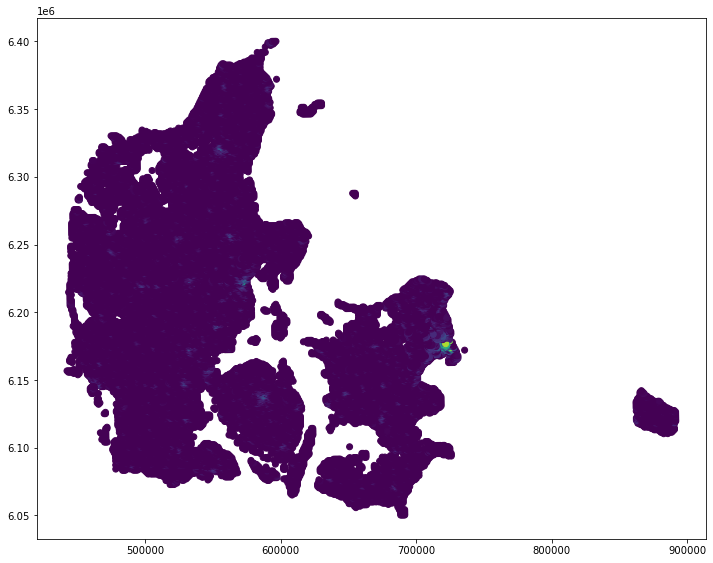

In [57]:
f, ax = plt.subplots(1, figsize=(12, 12))
ax = square_gdf_join.plot(column='pred',ax=ax)
plt.show()



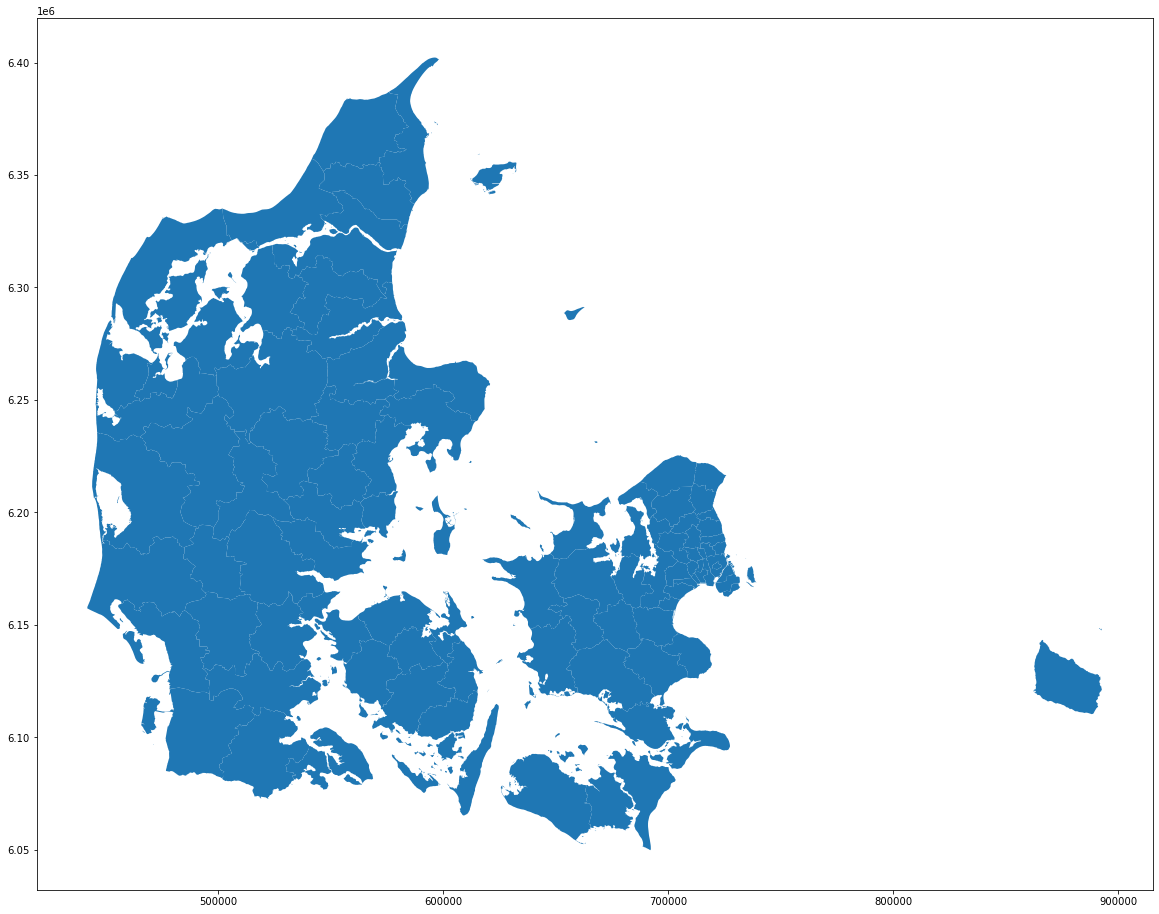

In [128]:
Kort = kommuner.plot(figsize=(20,20))

Jeg forsøger nu at danne et grid af små områder, til at opdele kortet. 